# Imports

- Python version: '3.8.5'
- numpy version: '1.19.2'
- matplotlib version: '3.3.4'
- pandas version: '1.2.3'
- sklearn version: '0.24.1'
- xgboost version: '1.3.1'
- joblib version: '1.0.1'
- hyperopt version: '0.2.5'
- rfpimp version: '1.3.2' (This version is incompitible with sklearn.forest module of the above mentioned version. You can either choose solve it by making changes in the rfpimp package or ignore this package as it is only used to get feature importance)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import joblib

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from rfpimp import *

# Useful functions

- Split the training data without shuffle to 10 parts using KFold
- For Training: Make model on 9 parts and predict the 10th part, this way predict all 10 parts
- For Testing: Make model on the whole training data and make prediction for the test data

In [3]:
def stack_features(clf_class, params, x, y, x_test, splits = 10):
    # for train data
    kf = KFold(n_splits=splits)
    predictions_train = np.zeros(shape=(x.shape[0]))
    for train, test in kf.split(x):
        clf = clf_class(**params)
        clf.fit(x.iloc[train,], y[train])
        predictions_train[test] = clf.predict(x.iloc[test,])
    
    #for test data
    clf = clf_class(**params)
    clf.fit(x,y)
    predictions_test = clf.predict(x_test)
    
    return [predictions_train, predictions_test]

# Data Loading

In [4]:
cct = pd.read_csv(r"data/cct_edvance_cleanp3.csv")

In [5]:
cct

,Counterfeit_Weight,Active_Since,Medicine_MRP,SidEffect_Level,Availability_rating,Counterfeit_Sales,Area_Type_DownTown,Area_Type_MidTownResidential,Area_Type_CityLimits,Area_City_Type_Tier_3,...,Area_dist_level_High,Medicine_Type_emb1,Medicine_Type_emb2,Medicine_Type_emb3,Active_Since_emb1,Active_Since_emb2,Active_Since_emb3,DistArea_ID_emb1,DistArea_ID_emb2,DistArea_ID_emb3
0,13.100,1995,160.2366,0,0.070422,1775.5026,1,0,0,0,...,0,3.510336,-7.387031,-4.339718,1.001297,-1.161068,-0.743231,-0.166057,1.468732,0.405775
1,7.450,1983,110.4384,1,0.013000,3069.1520,0,0,1,1,...,0,-1.580587,4.527868,3.424724,1.932892,-2.691388,-3.349833,1.619034,-3.540552,-4.789813
2,9.025,1995,259.4092,1,0.060783,2603.0920,1,0,0,0,...,0,-3.431630,-6.391154,2.535214,1.001297,-1.161068,-0.743231,-0.166057,1.468732,0.405775
3,11.800,1995,99.9830,1,0.065555,1101.7130,1,0,0,0,...,0,-6.806612,0.260040,-6.550432,1.001297,-1.161068,-0.743231,-0.166057,1.468732,0.405775
4,8.930,1983,56.4402,0,0.248859,158.9402,0,1,0,0,...,0,8.280236,-0.600299,-5.078403,1.932892,-2.691388,-3.349833,-0.949644,0.409351,-0.698435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,8.535,1995,204.1452,1,0.112963,2070.4520,1,0,0,0,...,0,8.280236,-0.600299,-5.078403,1.001297,-1.161068,-0.743231,-0.166057,1.468732,0.405775
6814,20.650,1995,235.1088,1,0.131103,2126.3792,1,0,0,0,...,0,8.280236,-0.600299,-5.078403,1.001297,-1.161068,-0.743231,-0.166057,1.468732,0.405775
6815,20.000,2005,193.6292,0,0.105096,2119.7212,1,0,0,0,...,0,3.510336,-7.387031,-4.339719,2.150422,0.255593,0.435376,-3.493427,-2.966176,-3.219448
6816,10.180,2000,162.8682,1,0.099957,1485.2138,1,0,0,0,...,0,2.255537,-6.626742,1.768149,1.340862,1.957803,2.081077,-0.417623,-6.242567,-0.536402


# Split to train and test

In [6]:
cct_train, cct_test = train_test_split(cct, test_size=0.2, random_state=123)
cct_train.reset_index(drop = True, inplace = True)
cct_test.reset_index(drop = True, inplace = True)

# Impute Missing Values
- using median
- without data leaking

In [7]:
counter_median = cct_train["Counterfeit_Weight"].median(axis = 0)
cct_train["Counterfeit_Weight"] = cct_train["Counterfeit_Weight"].fillna(counter_median)
cct_test["Counterfeit_Weight"] = cct_test["Counterfeit_Weight"].fillna(counter_median)


<ipython-input-7-a387cbfaec5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cct_train["Counterfeit_Weight"] = cct_train["Counterfeit_Weight"].fillna(counter_median)
<ipython-input-7-a387cbfaec5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cct_test["Counterfeit_Weight"] = cct_test["Counterfeit_Weight"].fillna(counter_median)


# Seperate Features and Target

In [8]:
cct_train_x, cct_train_y = cct_train.drop("Counterfeit_Sales", axis = 1), cct_train["Counterfeit_Sales"]
cct_test_x, cct_test_y = cct_test.drop("Counterfeit_Sales", axis = 1), cct_test["Counterfeit_Sales"]

# Standardize the data
- It helps in reaching the optimal value sooner.
- Equates the scales of all the features
- Helps in interpretability
- Omit all the columns with 0-1 values from standardization procedure

In [9]:
cols = ['Counterfeit_Weight', 'Medicine_MRP','Active_Since', 'Availability_rating',
        'Medicine_Type_emb1', 'Medicine_Type_emb2',
       'Medicine_Type_emb3', 'Active_Since_emb1', 'Active_Since_emb2',
       'Active_Since_emb3', 'DistArea_ID_emb1', 'DistArea_ID_emb2',
       'DistArea_ID_emb3']

sc = StandardScaler().fit(cct_train_x[cols])
temp_train = pd.DataFrame(sc.transform(X = cct_train_x[cols]), columns = cols)
temp_test = pd.DataFrame(sc.transform(X = cct_test_x[cols]), columns = cols)
cct_train_x.drop(cols, axis = 1, inplace = True)
cct_test_x.drop(cols, axis = 1, inplace = True)
cct_train_x = pd.concat([cct_train_x, temp_train], axis = 1)
cct_test_x = pd.concat([cct_test_x, temp_test], axis = 1)

# Modelling

## Linear Regression with Ridge regularisation

### Data selection for Ridge
- Its an iterative process of setting the hyperparameters and choosing the data

In [10]:
cct_train_x_rg = cct_train_x[['Medicine_MRP',
       'Active_Since_emb1', 'Active_Since_emb2', 'Active_Since_emb3',
       'Area_Type_DownTown', 'Area_Type_MidTownResidential', 'Area_Type_CityLimits',]]

cct_test_x_rg = cct_test_x[['Medicine_MRP',
       'Active_Since_emb1', 'Active_Since_emb2', 'Active_Since_emb3',
       'Area_Type_DownTown', 'Area_Type_MidTownResidential', 'Area_Type_CityLimits',]]

## Baysean Hyperparameter tuning for Ridge
- Baysean Hyperparameter selection quickens the process by consequetively selecting the Hyperparameter in the neighbourhood of improving results and moves in the improving direction rather then uniformly randomly selecting the Hyperparameters from the Hyperparameter space 

In [32]:
#%%
# Ridge regression with baysean parameter search :
# first iteration {'alpha': 29} 823.0753104042694
# second iteration{'alpha': 27} 823.0830734684687
# third iteration {'alpha': 31} 823.0769628954597
# fifth iteration {'alpha': 40} 823.1835213806038

# fine tune 1
# first iteration {'alpha': 29.84924623115578} 823.0743642266101
# second iteration {'alpha': 29.798994974874372} 823.0743608108548
# alpha = 37.537688442211056  821.1624251625575


def mae_model(params):
    clf = Ridge(**params)
    return cross_val_score(clf, cct_train_x_rg, cct_train_y, scoring = "neg_mean_absolute_error").mean()

# thecs = np.concatenate([np.linspace(0.0001, 1, 1000), np.linspace(1,700, 700)])
thecs = np.linspace(30, 50, 200)
param_space = {
    'alpha': hp.choice('alpha', thecs)
    }

best = -9999999999999999
def f(params):
    global best
    mae = mae_model(params)
    if mae > best:
        best = mae
    print ('new best:', best, params)
    return {'loss': -mae, 'status': STATUS_OK}

In [33]:
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=200, trials=trials)
print ('best:')
print (best)

new best:                                                                                                              
-820.7676275582141                                                                                                     
{'alpha': 32.41206030150754}                                                                                           
new best:                                                                                                              
-820.7676275582141                                                                                                     
{'alpha': 37.8391959798995}                                                                                            
new best:                                                                                                              
-820.7676275582141                                                                                                     
{'alpha': 47.185929648241206}           

-820.7668875958728                                                                                                     
{'alpha': 36.130653266331656}                                                                                          
new best:                                                                                                              
-820.7668875958728                                                                                                     
{'alpha': 43.5678391959799}                                                                                            
new best:                                                                                                              
-820.7668875958728                                                                                                     
{'alpha': 47.98994974874372}                                                                                           
new best:                               

{'alpha': 33.015075376884425}                                                                                          
new best:                                                                                                              
-820.7668875958728                                                                                                     
{'alpha': 32.01005025125628}                                                                                           
new best:                                                                                                              
-820.7668875958728                                                                                                     
{'alpha': 38.44221105527638}                                                                                           
new best:                                                                                                              
-820.7668875958728                      

new best:                                                                                                              
-820.7668799560736                                                                                                     
{'alpha': 34.120603015075375}                                                                                          
new best:                                                                                                              
-820.7668799560736                                                                                                     
{'alpha': 44.57286432160804}                                                                                           
new best:                                                                                                              
-820.7668799560736                                                                                                     
{'alpha': 30.90452261306533}            

-820.7668524180945                                                                                                     
{'alpha': 47.78894472361809}                                                                                           
new best:                                                                                                              
-820.7668524180945                                                                                                     
{'alpha': 33.91959798994975}                                                                                           
new best:                                                                                                              
-820.7668524180945                                                                                                     
{'alpha': 38.34170854271357}                                                                                           
new best:                               

### Final Ridge Model

In [11]:
clf_ridge = Ridge(alpha = 37.537688442211056).fit(cct_train_x_rg, cct_train_y)
pred_ridge = clf_ridge.predict(cct_test_x_rg)
score_ridge = 1 - (mean_absolute_error(cct_test_y, pred_ridge)/1660) # 0.4921322104466662
print(score_ridge)

0.49169270888893446


## Linear Regression with Lasso regularisation

### Data selection for Lasso
- is going to be same as Ridge

## Baysean Hyperparameter tuning for Lasso

In [67]:
#%%
# Lasso regression with baysean parameter search :
# first iteration {'alpha': 17} 821.7909391499858
# second iteration {'alpha': 11} 821.0466865240348
# third iteration {'alpha': 13} 821.1573067453025
# forth iteration {'alpha': 4} 821.5058931053937
# fifth iteration {'alpha': 10} 821.0464732229814

# fine tune1
# first iteration {'alpha': 10.527638190954773} 821.7909391499858
# alpha = 10.527638190954773

# fine tune2 made "Active_Since" numerical
# first iteration {'alpha': 9} 820.7950145922922
# second iteration {'alpha': 8.85929648241206} 820.7937802304436
# alpha = 8.85929648241206

def mae_model(params):
    clf = Lasso(max_iter = 2000, **params)
    return cross_val_score(clf, cct_train_x_rg, cct_train_y, scoring = "neg_mean_absolute_error", cv = 15).mean()

# thecs = np.concatenate([np.linspace(0.0001, 1, 1000), np.linspace(1,700, 700)])
thecs = np.linspace(8, 11, 200)
param_space = {
    'alpha': hp.choice('alpha', thecs)
    }

best = -9999999999999999
def f(params):
    global best
    mae = mae_model(params)
    if mae > best:
        best = mae
    print ('new best:', best, params)
    return {'loss': -mae, 'status': STATUS_OK}

In [68]:
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=200, trials=trials)
print ('best:')
print (best)

new best:                                                                                                              
-820.532784999195                                                                                                      
{'alpha': 8.467336683417086}                                                                                           
new best:                                                                                                              
-820.532784999195                                                                                                      
{'alpha': 8.49748743718593}                                                                                            
new best:                                                                                                              
-820.532784999195                                                                                                      
{'alpha': 10.743718592964823}           

-820.52606917016                                                                                                       
{'alpha': 9.77889447236181}                                                                                            
new best:                                                                                                              
-820.52606917016                                                                                                       
{'alpha': 9.748743718592966}                                                                                           
new best:                                                                                                              
-820.52606917016                                                                                                       
{'alpha': 8.618090452261306}                                                                                           
new best:                               

{'alpha': 10.080402010050252}                                                                                          
new best:                                                                                                              
-820.5250204296902                                                                                                     
{'alpha': 8.06030150753769}                                                                                            
new best:                                                                                                              
-820.5250204296902                                                                                                     
{'alpha': 8.587939698492463}                                                                                           
new best:                                                                                                              
-820.5244324807373                      

new best:                                                                                                              
-820.5244324807373                                                                                                     
{'alpha': 9.190954773869347}                                                                                           
new best:                                                                                                              
-820.5244324807373                                                                                                     
{'alpha': 9.64321608040201}                                                                                            
new best:                                                                                                              
-820.5244324807373                                                                                                     
{'alpha': 10.909547738693467}           

-820.5244324807373                                                                                                     
{'alpha': 9.809045226130653}                                                                                           
new best:                                                                                                              
-820.5244324807373                                                                                                     
{'alpha': 9.673366834170855}                                                                                           
new best:                                                                                                              
-820.5244324807373                                                                                                     
{'alpha': 9.839195979899497}                                                                                           
new best:                               

### Final Lasso Model

In [12]:
clf_lasso = Lasso(alpha = 8.85929648241206).fit(cct_train_x_rg, cct_train_y)
pred_lasso = clf_lasso.predict(cct_test_x_rg)
score_lasso = 1 - (mean_absolute_error(cct_test_y, pred_lasso)/1660) # 0.49168372175888797
print(score_lasso)

0.49190870074813386


### Stacking Predictions
- Making predictions on training and testing data using KFold
- This will later be used for stacking

In [13]:
param = {"alpha": 8.85929648241206}

pred_lasso = stack_features(clf_class = Lasso,
                            params = param,
                            x = cct_train_x, 
                            y = cct_train_y, 
                            x_test= cct_test_x,)

### Data selection for RandomForestRegressor
- This could be improved further as the feauter importance does not recomment using 'Medicine_Type'

In [14]:
cct_train_x_rf = cct_train_x[['Counterfeit_Weight', 'Medicine_MRP', 'SidEffect_Level',
       'Availability_rating','Active_Since','Medicine_Type_emb1', 'Medicine_Type_emb2', 'Medicine_Type_emb3',
       'DistArea_ID_emb1', 'DistArea_ID_emb2', 'DistArea_ID_emb3']]
cct_test_x_rf = cct_test_x[['Counterfeit_Weight', 'Medicine_MRP', 'SidEffect_Level',
       'Availability_rating','Active_Since','Medicine_Type_emb1', 'Medicine_Type_emb2', 'Medicine_Type_emb3',
       'DistArea_ID_emb1', 'DistArea_ID_emb2', 'DistArea_ID_emb3']]

## Baysean Hyperparameter tuning for RandomForestRegressor
- The parameter tuning could be improved futher by shirinking and narrowing the Hyperparameters range

In [44]:
# RandomForestRegressor with baysean parameter search
# {'criterion': "mae", 'max_depth': 49, 'max_features': 13, 'max_samples': 0.45, 'min_samples_leaf': 16, 'min_samples_split': 9, 'n_estimators': 205} 743.2759515191731

def mae_model(params):
    clf = RandomForestRegressor(n_jobs = 4, verbose = 1, **params)
    return cross_val_score(clf, cct_train_x_rf, cct_train_y, scoring = "neg_mean_absolute_error", cv = 10).mean()

param_space = { "criterion": hp.choice("criterion", ["mse", "mae"]),
                'max_depth': hp.choice("max_depth", [40,43,46,49,None]),
                'max_features': hp.choice("max_features", range(1, 19)),
                'max_samples': hp.choice("max_samples", np.linspace(0.3,0.95,14)),
                "min_samples_leaf": hp.choice("min_samples_leaf", range(1,20)),
                "min_samples_split": hp.choice("min_samples_split", range(2,20)),
                'n_estimators': hp.choice("n_estimators", range(100, 500))
                }

best = -9999999999999999
def f(params):
    global best
    mae = mae_model(params)
    if mae > best:
        best = mae
    print ('new best:', best, params)
    return {'loss': -mae, 'status': STATUS_OK}

In [45]:
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=60, trials=trials)
print ('best:')
print (best)

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-9999999999999999                                                                                                      
{'criterion': 'mae', 'max_depth': 43, 'max_features': 13, 'max_samples': 0.8499999999999999, 'min_samples_leaf': 16, 'min_samples_split': 17, 'n_estimators': 317}
 10%|██████▋                                                            | 1/10 [00:20<03:00, 20.04s/trial, best loss=?]

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-9999999999999999                                                                                                      
{'criterion': 'mse', 'max_depth': 49, 'max_features': 15, 'max_samples': 0.8999999999999999, 'min_samples_leaf': 7, 'min_samples_split': 11, 'n_estimators': 210}
 20%|█████████████▍                                                     | 2/10 [00:39<02:39, 19.94s/trial, best loss=?]

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-750.8209077357905                                                                                                     
{'criterion': 'mse', 'max_depth': None, 'max_features': 6, 'max_samples': 0.75, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 297}
 30%|███████████████                                   | 3/10 [00:49<01:45, 15.06s/trial, best loss: 750.8209077357905]

[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.4s

[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:    0.5s finished

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:    0.0s finished

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s

[Parallel(n_jobs=4)]: Done 174 out of 174 | elapsed:    0.1s finished

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 174 out of 174 | elapsed:    0.0s finished

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 174

new best:                                                                                                              
-750.8209077357905                                                                                                     
{'criterion': 'mse', 'max_depth': 43, 'max_features': 4, 'max_samples': 0.5, 'min_samples_leaf': 14, 'min_samples_split': 8, 'n_estimators': 174}
 40%|████████████████████                              | 4/10 [00:52<01:02, 10.41s/trial, best loss: 750.8209077357905]

[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 174 out of 174 | elapsed:    0.1s finished

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 174 out of 174 | elapsed:    0.0s finished

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
  

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-750.8209077357905                                                                                                     
{'criterion': 'mse', 'max_depth': 46, 'max_features': 13, 'max_samples': 0.8999999999999999, 'min_samples_leaf': 8, 'min_samples_split': 12, 'n_estimators': 269}
 50%|█████████████████████████                         | 5/10 [01:10<01:06, 13.27s/trial, best loss: 750.8209077357905]

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-750.8209077357905                                                                                                     
{'criterion': 'mse', 'max_depth': 43, 'max_features': 13, 'max_samples': 0.7999999999999999, 'min_samples_leaf': 9, 'min_samples_split': 16, 'n_estimators': 176}
 60%|██████████████████████████████                    | 6/10 [01:31<01:03, 15.82s/trial, best loss: 750.8209077357905]

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-750.8209077357905                                                                                                     
{'criterion': 'mse', 'max_depth': 43, 'max_features': 15, 'max_samples': 0.95, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 280}
 70%|███████████████████████████████████               | 7/10 [01:51<00:51, 17.11s/trial, best loss: 750.8209077357905]

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-747.0964109071933                                                                                                     
{'criterion': 'mae', 'max_depth': 49, 'max_features': 9, 'max_samples': 0.8499999999999999, 'min_samples_leaf': 11, 'min_samples_split': 2, 'n_estimators': 382}
 80%|███████████████████████████████████████▏         | 8/10 [06:38<03:26, 103.04s/trial, best loss: 747.0964109071933]

[Parallel(n_jobs=4)]: Done 382 out of 382 | elapsed:   27.6s finished

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s

[Parallel(n_jobs=4)]: Done 382 out of 382 | elapsed:    0.0s finished

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
  

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-747.0964109071933                                                                                                     
{'criterion': 'mae', 'max_depth': None, 'max_features': 12, 'max_samples': 0.5499999999999999, 'min_samples_leaf': 14, 'min_samples_split': 16, 'n_estimators': 346}
 90%|█████████████████████████████████████████████     | 9/10 [06:56<01:16, 76.54s/trial, best loss: 747.0964109071933]

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

new best:                                                                                                              
-747.0964109071933                                                                                                     
{'criterion': 'mae', 'max_depth': None, 'max_features': 16, 'max_samples': 0.39999999999999997, 'min_samples_leaf': 16, 'min_samples_split': 3, 'n_estimators': 120}
100%|█████████████████████████████████████████████████| 10/10 [07:15<00:00, 43.51s/trial, best loss: 747.0964109071933]
best:
{'criterion': 1, 'max_depth': 3, 'max_features': 8, 'max_samples': 11, 'min_samples_leaf': 10, 'min_samples_split': 0, 'n_estimators': 282}


C:\Users\iamen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 431, in _process_worker
    r = call_item()
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 285, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\iamen\anaconda3\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [f

### Final RandomForestRegressor Model

In [15]:
params = {"criterion": "mae",
          "max_depth": 46,
          "max_features": 11,
          "max_samples": 0.3,
          "min_samples_leaf": 17,
          "min_samples_split":18,
          "n_estimators": 269,
          }

clf = RandomForestRegressor(**params)

clf.fit(cct_train_x_rf, cct_train_y)
pred  = clf.predict(cct_test_x_rf)
print(1- (mean_absolute_error(cct_test_y, pred))/1660) # 0.5417561801599775

0.5403405076507449


### Stacking Predictions
- Making predictions on training and testing data using KFold
- This will later be used for stacking

In [16]:
param = {"criterion": "mae",
          "max_depth": 46,
          "max_features": 11,
          "max_samples": 0.3,
          "min_samples_leaf": 17,
          "min_samples_split":18,
          "n_estimators": 269,
          }

pred_rf = stack_features(clf_class = RandomForestRegressor,
                            params = param,
                            x = cct_train_x_rf, 
                            y = cct_train_y, 
                            x_test= cct_test_x_rf,)

# Feature Importance
- Add a column with random numbers in the dataframe
- Run RandomForest model and rank the use of each column
- The columns ranking lesser than the random values column are useless as they don't even show weak non linear relationship
- Ideally this should have been the first step for model building, but it has been sectioned here for relevance with RandomForest.
- Also the package rfpimp used for feature importance is buggy and incompitable with the above mentioned sklearn's version.

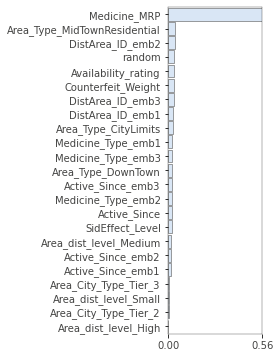

In [49]:
cct_train_x['random'] = np.random.random(size=len(cct_train_x))

params = {"criterion": "mae",
          "max_depth": 49,
          "max_features": 3,
          "max_samples": 0.95,
          "min_samples_leaf": 5,
          "min_samples_split": 6,
          "n_estimators": 500,
          "oob_score":True
          }
rf = RandomForestRegressor(n_jobs=8, **params)

rf.fit(cct_train_x,cct_train_y)

imp = importances(rf, cct_train_x, cct_train_y, n_samples=-1) # this function comes from package rfpimp
viz = plot_importances(imp)
viz.view()
cct_train_x.drop(["random"], axis = 1, inplace = True)

### Data selection for XGBoost

In [17]:
cct_train_x_xgb = cct_train_x[['Counterfeit_Weight', 'Medicine_MRP', 'SidEffect_Level',
       'Availability_rating', 'Active_Since',
       'Area_Type_DownTown', 'Area_Type_MidTownResidential', 'Area_Type_CityLimits',]]
cct_test_x_xgb = cct_test_x[['Counterfeit_Weight', 'Medicine_MRP', 'SidEffect_Level',
       'Availability_rating','Active_Since',                             
       'Area_Type_DownTown', 'Area_Type_MidTownResidential', 'Area_Type_CityLimits',]]

## Baysean Hyperparameter tuning for XGBoost

In [ ]:
def mae_model(params):
    clf = XGBRegressor(n_jobs = 4, **params)
    return cross_val_score(clf, cct_train_x_xgb, cct_train_y, scoring = "neg_mean_absolute_error", cv = 10).mean()

param_space = {
              'colsample_bytree': hp.choice("colsample_bytree",[0.9]),
              'gamma': hp.choice("gamma",[0.2, 0.3]),
              'learning_rate': hp.choice("learning_rate",[i/1000.0 for i in range(1,500)]),
              'max_depth': hp.choice("max_depth", [2,3,4,5]),
              'min_child_weight': hp.choice("min_child_weight",range(7,20)),
              'n_estimators': hp.choice("n_estimators",range(100,700)),
              'reg_alpha': hp.choice("reg_alpha",[1e-5, 1e-2, 0.1, 1, 100]),
              'subsample': hp.choice("subsample",[i/10.0 for i in range(6,9)]),
              }

best = -9999999999999999
def f(params):
    global best
    mae = mae_model(params)
    if mae > best:
        best = mae
    print ('new best:', best, params)
    return {'loss': -mae, 'status': STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=180, trials=trials)
print ('best:')
print (best)

### Final XGBoost Model

In [18]:
params ={'colsample_bytree': 0.9, 
         'gamma': 0.3, 
         'learning_rate': 0.008, 
         'max_depth': 4, 
         'min_child_weight': 11, 
         'n_estimators': 408, 
         'reg_alpha': 100, 
         'subsample': 0.6}
clf = XGBRegressor(**params)

clf.fit(cct_train_x_xgb, cct_train_y)
pred  = clf.predict(cct_test_x_xgb)
print(1- (mean_absolute_error(cct_test_y, pred))/1660)

0.5431732913817648


### Stacking Predictions
- Making predictions on training and testing data using KFold
- This will later be used for stacking

In [19]:
param = {'colsample_bytree': 0.9, 
         'gamma': 0.3, 
         'learning_rate': 0.008, 
         'max_depth': 4, 
         'min_child_weight': 11, 
         'n_estimators': 408, 
         'reg_alpha': 100, 
         'subsample': 0.6}

pred_xgb = stack_features(clf_class = XGBRegressor,
                            params = param,
                            x = cct_train_x_xgb, 
                            y = cct_train_y, 
                            x_test= cct_test_x_xgb,)

### Data selection for SVR

In [20]:
cct_train_x_svm = cct_train_x[['Area_Type_DownTown', 'Area_Type_MidTownResidential','Area_Type_CityLimits', 'Active_Since_emb1', 'Active_Since_emb2','Active_Since_emb3', 'Medicine_MRP']]
cct_test_x_svm = cct_test_x[['Area_Type_DownTown', 'Area_Type_MidTownResidential','Area_Type_CityLimits', 'Active_Since_emb1', 'Active_Since_emb2','Active_Since_emb3', 'Medicine_MRP']]

## Baysean Hyperparameter tuning for SVR

In [ ]:
# Suppor Vector machines with baysean parameter search
# first iteration{'C': 4, 'epsilon': 8, 'gamma': 0}  941.418253884028
# second iteration {'C': 4, 'epsilon': 7, 'gamma': 0} 941.5574122674225
# third iteration{'C': 5, 'epsilon': 7, 'gamma': 0} 941.5574122674225
# fourth iteration{'C': 5, 'epsilon': 3, 'gamma': 0} 941.5767796368382
# fifth iteration{'C': 5, 'epsilon': 8, 'gamma': 0} 941.418253884028
# sixth iteration {'C': 5, 'epsilon': 7, 'gamma': 0}941.5574122674225
# gamma = "scale"

# fine tune1
# first iteration{'C': 8, 'epsilon': 19}  941.0225289122075
# second iteration{'C': 8, 'epsilon': 16}  941.0501021014394
# third iteration{'C': 8, 'epsilon': 19}  941.0225289122075
# forth iteration{'C': 8, 'epsilon': 19}  941.0225289122075

# fine tune2
# first iteration {'C': 99, 'epsilon': 57} 879.0660582394387
# second iteration{'C': 99, 'epsilon': 31} 879.2227147509797
# third iteration{'C': 197, 'epsilon': 41} 853.1682112855945
# fourth iteration{'C': 198, 'epsilon': 61} 853.1123688260808
# sixth iteration {'C': 295, 'epsilon': 7}  839.7500903667018
# seventh iteration{'C': 293, 'epsilon': 4} 839.9542300908046
# eighth iteration {'C': 398, 'epsilon': 35} 830.149343925055
# ninth iteration {'C': 394, 'epsilon': 37} 830.3509412481368
# {'C': 380, 'epsilon': 46} 825.3215946401036
# {'C': 398, 'epsilon': 46} 824.4356218933086
# {'C': 299, 'epsilon': 11} 815.8232476871206
# {'C': 297, 'epsilon': 34} 815.8941187750149
# {'C': 247, 'epsilon': 78} 810.2516946713666
# {'C': 247, 'epsilon': 58} 810.3448101966028
# {'C': 539, 'epsilon': 2} 802.120331269758
# {'C': 547, 'epsilon': 11} 802.0276917258524
# {'C': 543, 'epsilon': 8}  796.797930764249
# {'C': 544, 'epsilon': 28} 797.1442858237865
# {'C': 981, 'epsilon': 31} 790.7450758859607
# {'C': 974, 'epsilon': 2} 758.7677413615756
# proper values here onwards:
# {'C': 3860, 'epsilon': 28} 743.6608804498499
# {'C': 3878, 'epsilon': 31} 744.176057143124
# {'C': 3989, 'epsilon': 5} 744.0879265913878
# {'C': 3759, 'epsilon': 9} 743.6426201040025
# {'C': 717, 'epsilon': 9} 743.6452143096697 
# {'C': 785, 'epsilon': 8} 743.6540162014312
# {'C': 5473, 'epsilon': 20} 736.6245910411776 removed "Availability_rating" "Counterfeit_Weight"
# {'C': 4637, 'epsilon': 20} 736.7069403701109
# {'C': 5153, 'epsilon': 1} 735.9877743734398
# {'C': 5154, 'epsilon': 1} 735.9871399023639
# {'C': 5117, 'epsilon': 1} 735.9837570948728
# {'C': 5147, 'epsilon': 2} 735.9823847096891
# {'C': 5095, 'epsilon': 1.99} 735.7256231695428
# {'C': 5090, 'epsilon': 2.01} 735.7250519294928
# {'C': 5062, 'epsilon': 2.01} 735.7250139797717

 
def mae_model(params):
    clf = SVR(verbose = 1, kernel = "rbf", gamma = "scale", **params)
    return cross_val_score(clf, cct_train_x_svm, cct_train_y, scoring = "neg_mean_absolute_error", cv = 10).mean()

# param_space = {
#               # 'epsilon': hp.choice("epsilon",[0.01,0.05,0.1,0.3,0.5, 0.7, 1.0, 2.0, 10.0]),
#               'epsilon': hp.choice("epsilon",np.linspace(2, 21, 20)),
#               'C': hp.choice("C",np.linspace(20, 100, 9)),
#               # 'gamma': hp.choice("gamma",['scale', 'auto'])
#               }

param_space = {
              'epsilon': hp.choice("epsilon",range(20,100)),
              'C': hp.choice("C",range(100, 200))
              }

best = -9999999999999999
def f(params):
    global best
    mae = mae_model(params)
    if mae > best:
        best = mae
    print ('new best:', best, params)
    return {'loss': -mae, 'status': STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=90, trials=trials)
print ('best:')
print (best)

### Final SVR Model

In [21]:
params ={'epsilon': 2.01, 
         'C': 5062}
clf_svr = SVR(kernel = "rbf", gamma = "scale", **params)

clf_svr.fit(cct_train_x_svm, cct_train_y)
pred  = clf_svr.predict(cct_test_x_svm)
print(1- (mean_absolute_error(cct_test_y, pred))/1660) # 0.547651025513799

0.5475850701092899


### Stacking Predictions
- Making predictions on training and testing data using KFold
- This will later be used for stacking

In [22]:
param = {'epsilon': 2.01, 
         'C': 5062,
         'kernel': "rbf",
         'gamma': "scale"}

pred_svr = stack_features(clf_class = SVR,
                            params = param,
                            x = cct_train_x_svm, 
                            y = cct_train_y, 
                            x_test= cct_test_x_svm,)

### Data selection for KNN

In [23]:
cct_train_x_knn = cct_train_x[['Area_Type_DownTown', 'Area_Type_MidTownResidential','Area_Type_CityLimits', 'Active_Since_emb1', 'Active_Since_emb2','Active_Since_emb3', 'Medicine_MRP']]
cct_test_x_knn = cct_test_x[['Area_Type_DownTown', 'Area_Type_MidTownResidential','Area_Type_CityLimits', 'Active_Since_emb1', 'Active_Since_emb2','Active_Since_emb3', 'Medicine_MRP']]

## Baysean Hyperparameter tuning for KNN

In [ ]:
# KNN with baysean parameter search
# first iteration {{'n_neighbors': 2, 'weights': 1}
# second iteration{'n_neighbors': 2, 'p': 1, 'weights': 1} 875.3344788065913
# third iteration {'n_neighbors': 3, 'p': 0, 'weights': 1} 872.6920289598384
# fourth iteration{'n_neighbors': 4, 'p': 0, 'weights': 1} 873.533967219841
# fifth iteration {'n_neighbors': 2, 'p': 1, 'weights': 1} 875.3344788065913
# weights = "distance"

# fine tune
# first iteration {'n_neighbors': 5, 'p': 0} 872.1502457971421
# second iteration{'n_neighbors': 4, 'p': 0} 872.6920289598384
# third iteration {'n_neighbors': 4, 'p': 0} 872.6920289598384
# fourth iteration{'n_neighbors': 5, 'p': 0} 872.1502457971421
# n_neighbors = 11, p = 1

# fine tune1 after feature selection, same data from svm is passed to knn also
# iter 1 {'n_neighbors': 13, 'p': 0} 777.9640311556376
# iter 2 {'n_neighbors': 22, 'p': 0} 771.0710755862913
# iter 3 {'n_neighbors': 25, 'p': 0} 765.9120744982008 removed "SidEffect_Level"
# iter 4 {'n_neighbors': 30, 'p': 0} 753.8320804583398 removed "Availability_rating" also
# iter 5 {'n_neighbors': 49, 'p': 0} 744.6360464712334 removed "Counterfeit_Weight" also
# the columns that work: 'Area_Type_DownTown', 'Area_Type_MidTownResidential','Area_Type_CityLimits', 'Active_Since_emb1', 'Active_Since_emb2','Active_Since_emb3', 'Medicine_MRP'
# n_neighbours = 49, p = 1
def mae_model(params):
    clf = KNeighborsRegressor(**params)
    return cross_val_score(clf, cct_train_x_knn, cct_train_y, scoring = "neg_mean_absolute_error", cv = 10).mean()

# param_space = {
#               'n_neighbors': hp.choice("n_neighbors",[3,5,7,10,12,15,20]),
#               'weights': hp.choice("weights",["uniform", 'distance']),
#               }

param_space = {
              # 'n_neighbors': hp.choice("n_neighbors",[6,7, 8, 9, 10, 11, 12,13]),
              'n_neighbors': hp.choice("n_neighbors",np.arange(12, 50)),
               'p': hp.choice("p",[1,2,3,4])
              }

best = -9999999999999999
def f(params):
    global best
    mae = mae_model(params)
    if mae > best:
        best = mae
    print ('new best:', best, params)
    return {'loss': -mae, 'status': STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

### Final KNN Model

In [24]:
params ={'weights': "distance", 
         'n_neighbors': 49, 
         'p': 1}
clf_knn = KNeighborsRegressor(**params)

clf_knn.fit(cct_train_x_knn, cct_train_y)
pred  = clf_knn.predict(cct_test_x_knn)
print(1- (mean_absolute_error(cct_test_y, pred))/1660) # 0.5049861381599288

0.5049880052725446


### Stacking Predictions
- Making predictions on training and testing data using KFold
- This will later be used for stacking

In [25]:
param = {'weights': "distance", 
         'n_neighbors': 49, 
         'p': 1}

pred_knn = stack_features(clf_class = KNeighborsRegressor,
                            params = param,
                            x = cct_train_x_knn, 
                            y = cct_train_y, 
                            x_test= cct_test_x_knn,)

# Stacking

## Collecting data
- The predictions made after all the modelling will be consolidated.

In [26]:
cct_train_x_stack = pd.DataFrame({"pred_lasso": pred_lasso[0],
                          "pred_svr": pred_svr[0],
                          "pred_knn": pred_knn[0],
                          "pred_rf": pred_rf[0],
                          "pred_xgb": pred_xgb[0]})

cct_test_x_stack = pd.DataFrame({"pred_lasso": pred_lasso[1],
                          "pred_svr": pred_svr[1],
                          "pred_knn": pred_knn[1],
                          "pred_rf": pred_rf[1],
                          "pred_xgb": pred_xgb[1]})

## Modelling
- Make a Linear Regression with Ridge Regularisation model for this data

In [27]:
clf_ridge = Ridge(alpha = 0.004103603603603604).fit(cct_train_x_stack, cct_train_y)
pred_ridge = clf_ridge.predict(cct_test_x_stack)
score_ridge = 1 - (mean_absolute_error(cct_test_y, pred_ridge)/1660)
print(score_ridge)

0.546498718350047


# Saving the Model
- This model can then be used in production

In [33]:
joblib.dump(clf_ridge, "model/stacked_model.pkl")

['model/stacked_model.pkl']

# Retriveing the Model
- Load the saved model in the production environment
- Saving and Retriveing the model should happen with the same version of 'joblib' and 'pickle', or else it would lead to inconsistencies.

In [34]:
clf_ridge = joblib.load("model/stacked_model.pkl")

In [35]:
pred_ridge = clf_ridge.predict(cct_test_x_stack)
print("Final Prediction:", pred_ridge)

Final Prediction: [ 188.73934652 4357.99716267 4835.15944947 ... 1649.32934772 5952.24162506
  636.97933714]
